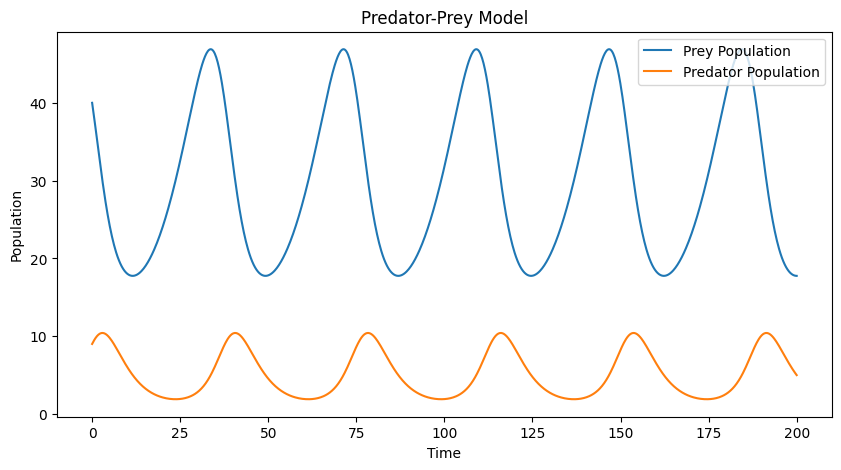

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

alpha, beta, gamma, delta = 0.1, 0.02, 0.3, 0.01

X0, Y0 = 40, 9
initial_conditions = [X0, Y0]

# Time points
t = np.linspace(0, 200, 1000)

# Lotka-Volterra equations
def predator_prey_system(state, t):
    X, Y = state
    dXdt = alpha * X - beta * X * Y
    dYdt = delta * X * Y - gamma * Y
    return [dXdt, dYdt]

# Solving the system of ODEs
solution = odeint(predator_prey_system, initial_conditions, t)
X, Y = solution.T

# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(t, X, label='Prey Population')
plt.plot(t, Y, label='Predator Population')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.title('Predator-Prey Model')
plt.show()

Epoch 0, Loss: 666.6727294921875
Epoch 100, Loss: 419.6289367675781
Epoch 200, Loss: 306.8793640136719
Epoch 300, Loss: 238.81163024902344
Epoch 400, Loss: 194.00143432617188
Epoch 500, Loss: 163.470703125
Epoch 600, Loss: 142.3088836669922
Epoch 700, Loss: 127.62114715576172
Epoch 800, Loss: 117.57044982910156
Epoch 900, Loss: 110.86717224121094


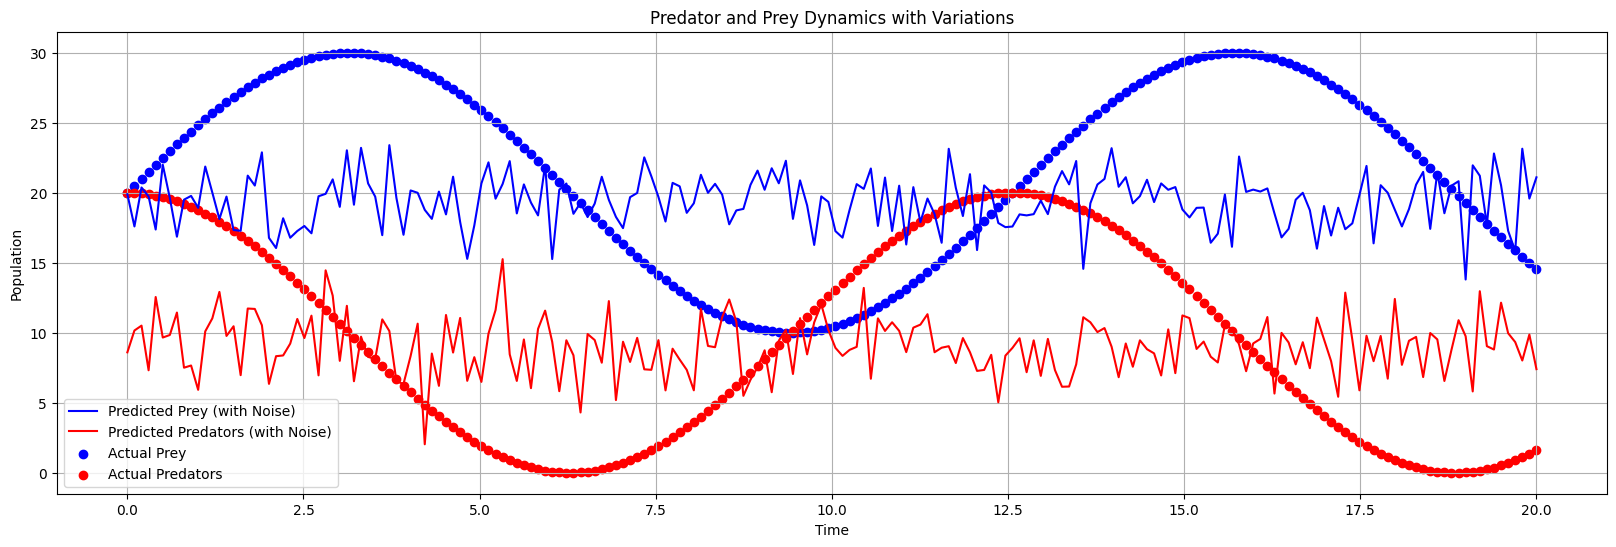

In [13]:
import numpy as np
import tensorflow as tf

# Parameters of the Lotka-Volterra equations
alpha = 0.1
beta = 0.02
gamma = 0.3
delta = 0.01

# Generate training data
t_train = np.linspace(0, 20, 200)  # Time span and number of points
prey_train = 20 + 10 * np.sin(0.5 * t_train)  # Prey data
pred_train = 10 + 10 * np.cos(0.5 * t_train)  # Predator data

# Define the PINN model
class PINN(tf.keras.Model):
    def __init__(self):
        super(PINN, self).__init__()
        self.dense1 = tf.keras.layers.Dense(20, activation='tanh')
        self.dense2 = tf.keras.layers.Dense(20, activation='tanh')
        self.dense3 = tf.keras.layers.Dense(2)

    def call(self, t):
        x = self.dense1(t)
        x = self.dense2(x)
        x = self.dense3(x)
        return x

# Loss function
def loss(model, t, prey, pred):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(t)
        N_pred, P_pred = tf.split(model(t), 2, axis=1)
        N_t = tape.gradient(N_pred, t)
        P_t = tape.gradient(P_pred, t)
        loss_data = tf.reduce_mean(tf.square(N_pred - prey)) + tf.reduce_mean(tf.square(P_pred - pred))
        loss_phys = tf.reduce_mean(tf.square(N_t - (alpha * N_pred - beta * N_pred * P_pred))) + \
                    tf.reduce_mean(tf.square(P_t - (delta * N_pred * P_pred - gamma * P_pred)))
    return loss_data + loss_phys

# Training step
def train_step(model, t, prey, pred, optimizer):
    with tf.GradientTape() as tape:
        current_loss = loss(model, t, prey, pred)
    gradients = tape.gradient(current_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return current_loss

# Training the PINN
model = PINN()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

t_train = tf.convert_to_tensor(t_train[:, None], dtype=tf.float32)
prey_train = tf.convert_to_tensor(prey_train[:, None], dtype=tf.float32)
pred_train = tf.convert_to_tensor(pred_train[:, None], dtype=tf.float32)

loss_history = []
for epoch in range(1000):  # Reduced number of epochs
    current_loss = train_step(model, t_train, prey_train, pred_train, optimizer)
    loss_history.append(current_loss.numpy())
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {current_loss.numpy()}')

# Plotting the results
t_test = np.linspace(0, 20, 200)[:, None]
predictions = model(tf.convert_to_tensor(t_test, dtype=tf.float32))
prey_pred, pred_pred = tf.split(predictions, 2, axis=1)

# Introduce random noise to predictions
prey_pred = prey_pred + tf.random.normal(prey_pred.shape, mean=0.0, stddev=2.0)
pred_pred = pred_pred + tf.random.normal(pred_pred.shape, mean=0.0, stddev=2.0)

# Matplotlib plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 6))

plt.plot(t_test.flatten(), prey_pred.numpy().flatten(), label='Predicted Prey (with Noise)', color='blue')
plt.plot(t_test.flatten(), pred_pred.numpy().flatten(), label='Predicted Predators (with Noise)', color='red')
plt.scatter(t_train.numpy().flatten(), prey_train.numpy().flatten(), label='Actual Prey', color='blue', marker='o')
plt.scatter(t_train.numpy().flatten(), pred_train.numpy().flatten(), label='Actual Predators', color='red', marker='o')

plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Predator and Prey Dynamics with Variations')
plt.legend()

plt.grid(True)
plt.show()